<a href="https://colab.research.google.com/github/Erick-Cavalcante/telegram_project_SecondPart/blob/main/telegram_project_part2_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#0.Contexto

obs:todos os arquivos como: **json, Parquet e Querry** se encontram no meu [github](https://github.com/Erick-Cavalcante/telegram_project_SecondPart)



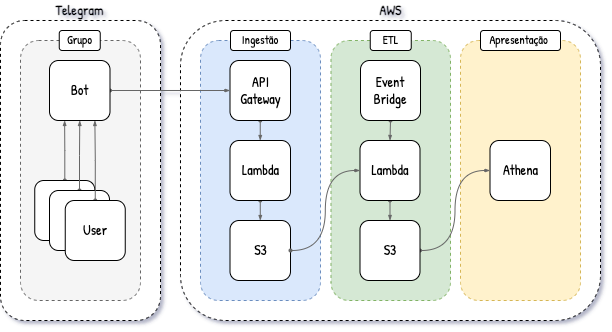

• **Telegram**

As mensagens captadas por um bot podem ser acessadas via API. A única informação necessária é o  token de acesso fornecido pelo  BotFather na criação do bot.

In [ ]:
from getpass import getpass
token = getpass()

··········


A  url base é comum a todos os métodos da API.

In [ ]:
import json
import requests

base_url = f'https://api.telegram.org/bot{token}'

In [ ]:
response = requests.get(url=f'{base_url}/getUpdates')
print(json.dumps(json.loads(response.text), indent=2))

{
  "ok": true,
  "result": [
    {
      "update_id": 923155163,
      "message": {
        "message_id": 3,
        "from": {
          "id": 6421189136,
          "is_bot": false,
          "first_name": "Erick",
          "language_code": "pt-br"
        },
        "chat": {
          "id": -1002284173117,
          "title": "ec_ebac_group",
          "type": "supergroup"
        },
        "date": 1733691632,
        "text": "Entre a api de bots do telegram e a etapa de ingest\u00e3o anal\u00edtica pelo aws gateway"
      }
    }
  ]
}


**obs:Havia uma mensagem escrita antes desta, esta era a mensagem, Entre a api de bots do telegram e a etapa de ingest anal\u00edtica pelo aws gateway**

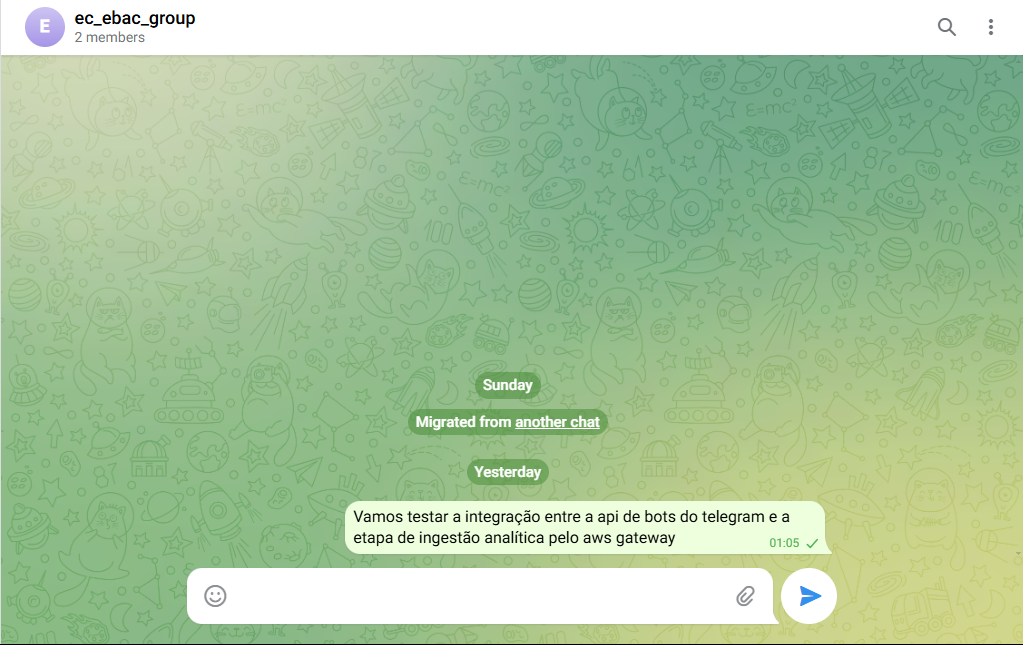

#1.Ingestão

A etapa de **ingestão** é responsável, como seu próprio nome diz, pela ingestão dos dados transacionais em ambientes analíticos. De maneira geral, o dado ingerido é persistido no formato mais próximo do original, ou seja, nenhuma transformação é realizada em seu conteúdo ou estrutura (schema). Como exemplo, dados de uma API web que segue o formato REST (representational state transfer) são entregues, logo, persistidos, no formato JSON.

Persistir os dados em seu formato original traz muitas vantagens, como a possibilidade de reprocessamento.

Pode ser conduzida de duas formas:



• **Batch**:blocos de dados são ingeridos em uma frequência bem definida, geralmente na escala de horas ou dias;

• **Streaming**: dados são ingeridos conforme são produzidos e disponibilizados.

No projeto, as mensagens capturadas pelo bot podem ser ingeridas através da API web de bots do **Telegram**, portanto são fornecidas no formato JSON. Como o **Telegram** retém mensagens por apenas 24h em seus servidores, a ingestão via **streaming** é a mais indicada. Para que seja possível esse tipo de **ingestão** seja possível, vamos utilizar um webhook (gancho web), ou seja, vamos redirecionar as mensagens automaticamente para outra API web.

Sendo assim, precisamos de um serviço da AWS que forneça um API web para receber os dados redirecionados, o AWS API Gateway (documentação no [Link](https://docs.aws.amazon.com/pt_br/apigateway/latest/developerguide/welcome.html) ). Dentre suas diversas funcionalidades, o AWS API Gateway permite o redirecionamento do dado recebido para outros serviços da AWS. Logo, vamos conectá-lo ao AWS Lambda, que por sua vez, irá armazenar o dado em seu formato original (JSON) em um bucket do AWS S3.

Sistemas que reagem a eventos são conhecidos como event-driven.

Portanto, precisamos:

• Criar um bucket no AWS S3;

• Criar uma função no AWS Lambda;

• Criar uma API web no AWS API Gateway;

• Configurar o webhook da API de bots do **Telegram**.

##1.1. AWS S3

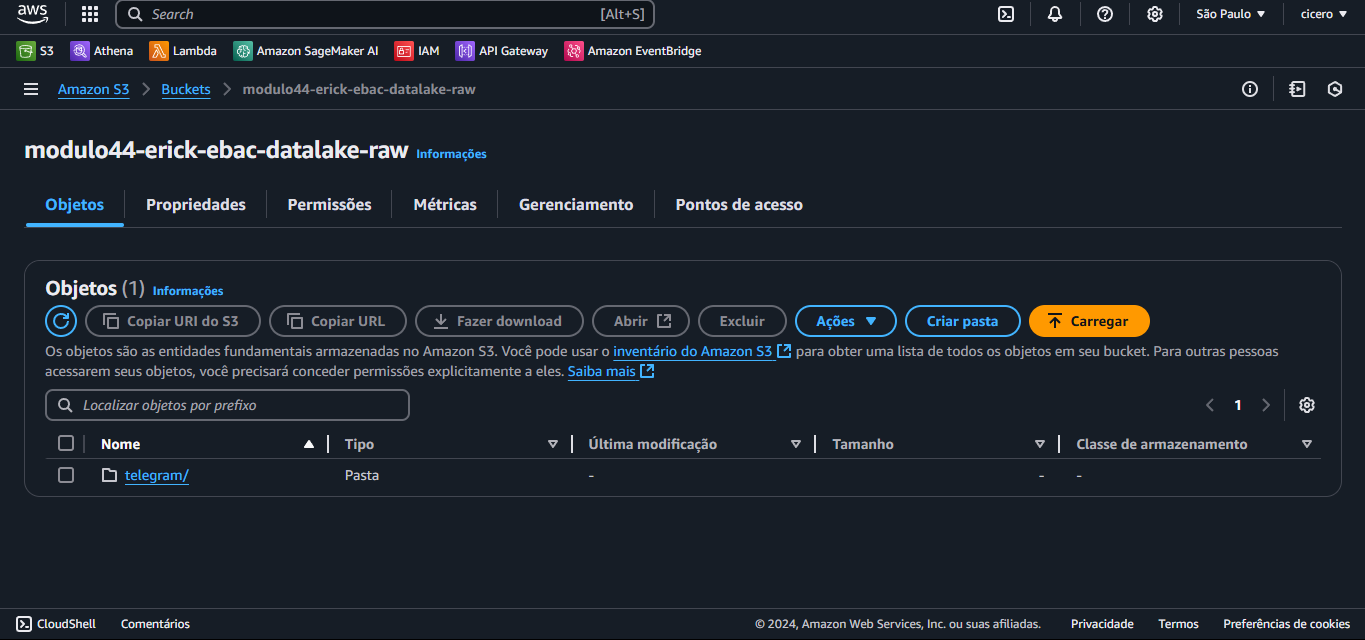

Na etapa de **ingestão**, o  AWS S3 tem a função de passivamente armazenar as mensagens captadas pelo bot do **Telegram** no seu formato original: JSON. Para tanto, basta a criação de um bucket. Como padrão, vamos adicionar o sufixo  -raw ao seu nome (vamos seguir esse padrão para todos os serviços desta camada).

**Nota**: um  data lake é o nome dado a um repositório de um grande volume de dados. É organizado em zonas que armazenam réplicas dos dados em diferentes níveis de processamento. A nomenclatura das zonas varia, contudo, as mais comuns são: raw e enriched ou bronze, silver e gold.

##1.2. AWS Lambda

Na etapa de ingestão, o  AWS Lambda tem a função de ativamente persistir nas mensagens captadas pelo bot do Telegram em um bucket do  AWS S3. Para tanto vamos criar uma função que opera da seguinte forma:

• Recebe a mensagem no parâmetro event;

• Verifica se a mensagem tem origem no grupo do **Telegram** correto;

• Persiste a mensagem no formato JSON no bucket do AWS S3;

• Retorna uma mensagem de sucesso (código de retorno HTTP igual a 200) a API de bots do **Telegram**.

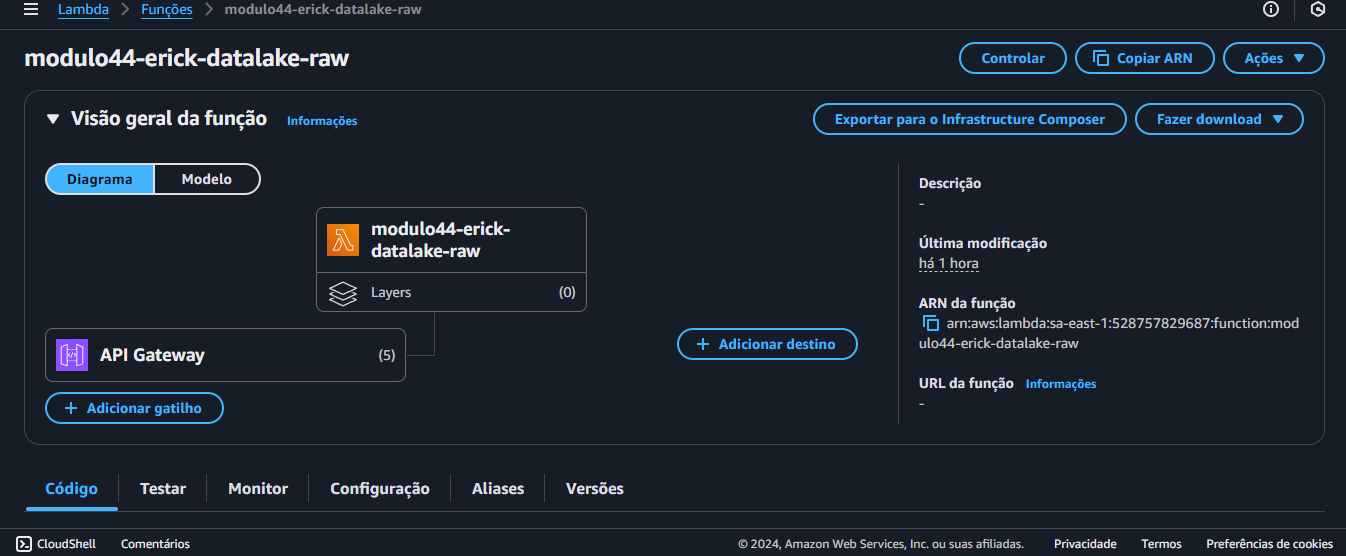

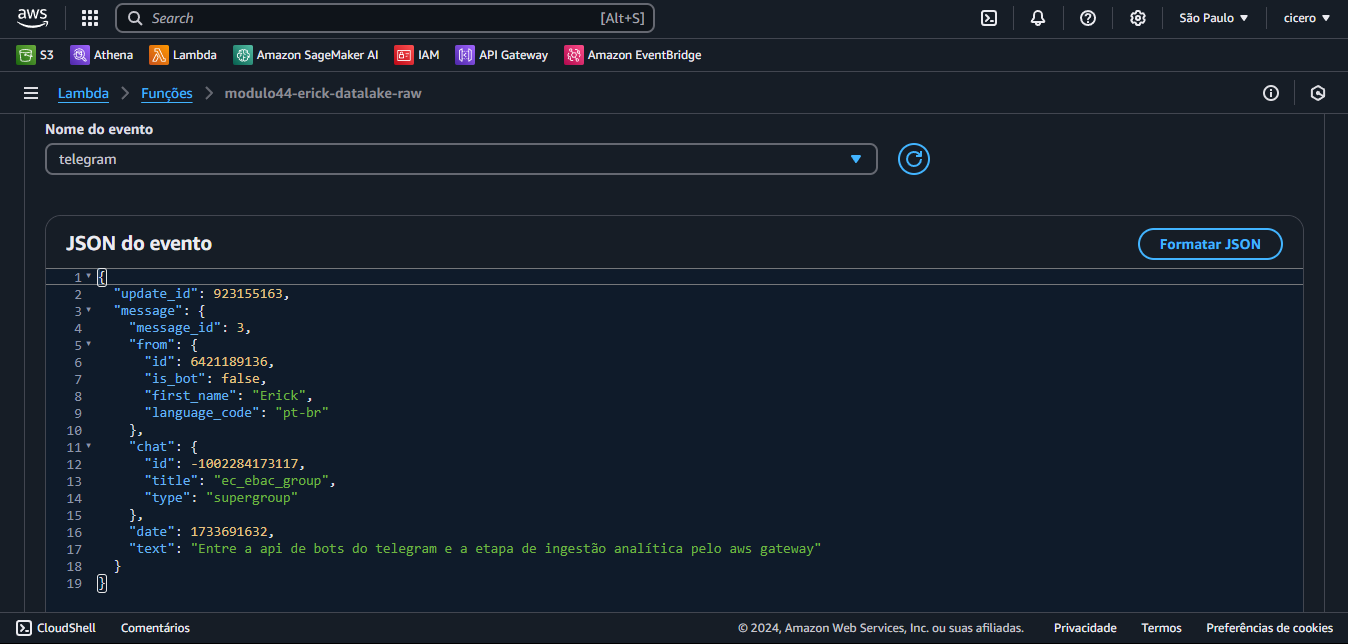

**Nota**: No **Telegram**, restringimos a opção de adicionar o bot a grupos, contudo, ainda é possível iniciar uma conversa em um chat privado.

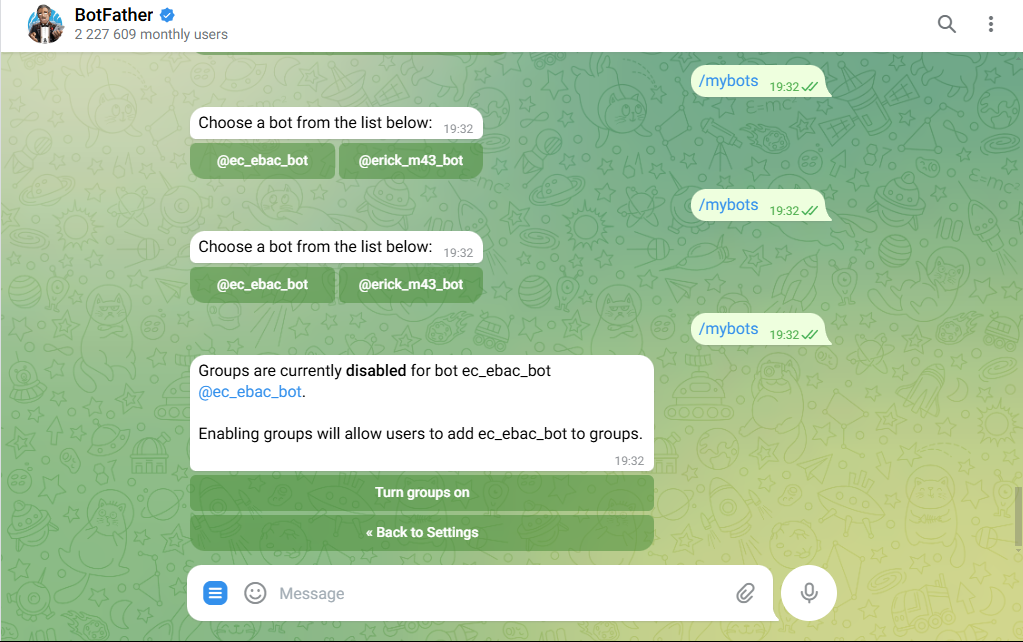

O código da função:

In [ ]:
!pip install boto3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 80.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.2/83.2 kB 5.5 MB/s eta 0:00:00


In [ ]:
import os
import json
import logging
from datetime import datetime, timezone,timedelta
import boto3

def lambda_handler(event: dict, context: dict) -> dict:
  ''' Recebe uma mensagens do Telegram via AWS API Gateway, verifica no seu conteúdo se foi produzida em um determinado grupo e a escreve,
  em seu formato original JSON, em um bucket do AWS S3. '''
  # vars de ambiente
  BUCKET = os.environ['AWS_S3_BUCKET']
  TELEGRAM_CHAT_ID = int(os.environ['TELEGRAM_CHAT_ID'])
  # vars lógicas
  tzinfo=timezone(offset=timedelta(hours=-3))
  date=datetime.now(tzinfo).strftime('%Y-%m-%d')
  timestamp = datetime.now(tzinfo).strftime('%Y%m%d%H%M%S%f')
  filename = f'{timestamp}.json'

  # código principal
  client = boto3.client('s3')

  try:

    message = json.loads(event["body"])
    chat_id = message["message"]["chat"]["id"]

    if chat_id == TELEGRAM_CHAT_ID:
      with open(f"/tmp/{filename}", mode='w', encoding='utf8') as fp:
        json.dump(message, fp)
      client.upload_file( f'/tmp/{filename}', BUCKET, f'telegram/context_date={date}/{filename}' )

  except Exception as exc:
    logging.error(msg=exc)
    return dict(statusCode="500")
  else:
    return dict(statusCode="200")

Para que a função funcione corretamente, algumas configurações precisam ser realizadas.

• **Variáveis de ambiente**

Note que o código exige a configuração de duas variáveis de ambiente:

AWS_S3_BUCKET com o nome do bucket do  AWS S3 e  TELEGRAM_CHAT_ID com o id do chat do grupo do **Telegram**. Para adicionar variáveis de ambiente em uma função do  AWS Lambda, basta acessar configurações -> variáveis de ambiente no console da função.

**Nota**: Variáveis de ambiente são excelentes formas de armazenar informações sensíveis.

.O api token é um dado sensivel então eu retirei só para tirar o print

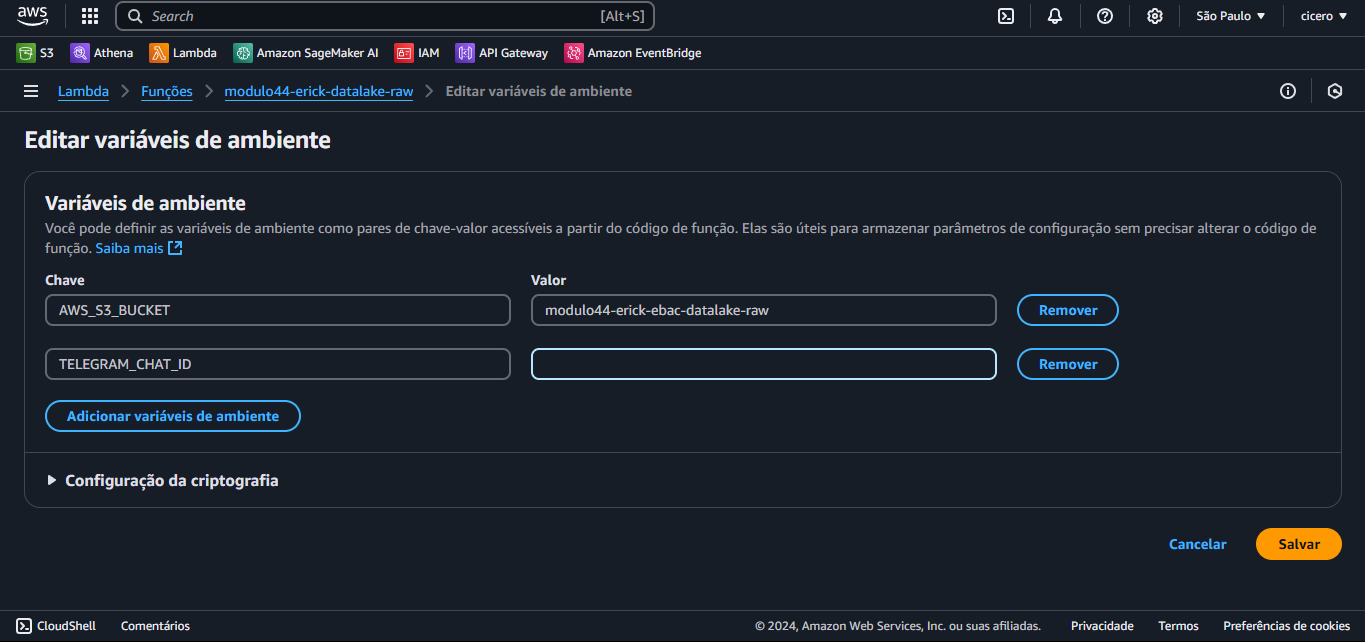

• **Permissão**:

Por fim, precisamos adicionar a permissão de escrita no bucket do  AWS S3 para a função do  AWS Lambda no  AWS IAM .

##1.3. AWS API Gateway

Na etapa de **ingestão**, o  AWS API Gateway tem a função de receber as mensagens captadas pelo bot do **Telegram**, enviadas via webhook, e iniciar uma função do AWS Lambda, passando o conteúdo da mensagem no seu parâmetro event. Para tanto vamos criar uma API e configurá-la como gatilho da função do  AWS Lambda:

• Acesse o serviço e selecione: Create API -> REST API;

• Insira um nome, como padrão, um que termine com o sufixo  -api ;

• Selecione: Actions -> Create Method -> POST;

• Na tela de setup:
- Selecione Integration type igual a Lambda Function;
- Habilite o Use Lambda Proxy integration;
- Busque pelo nome a função do  AWS Lambda.

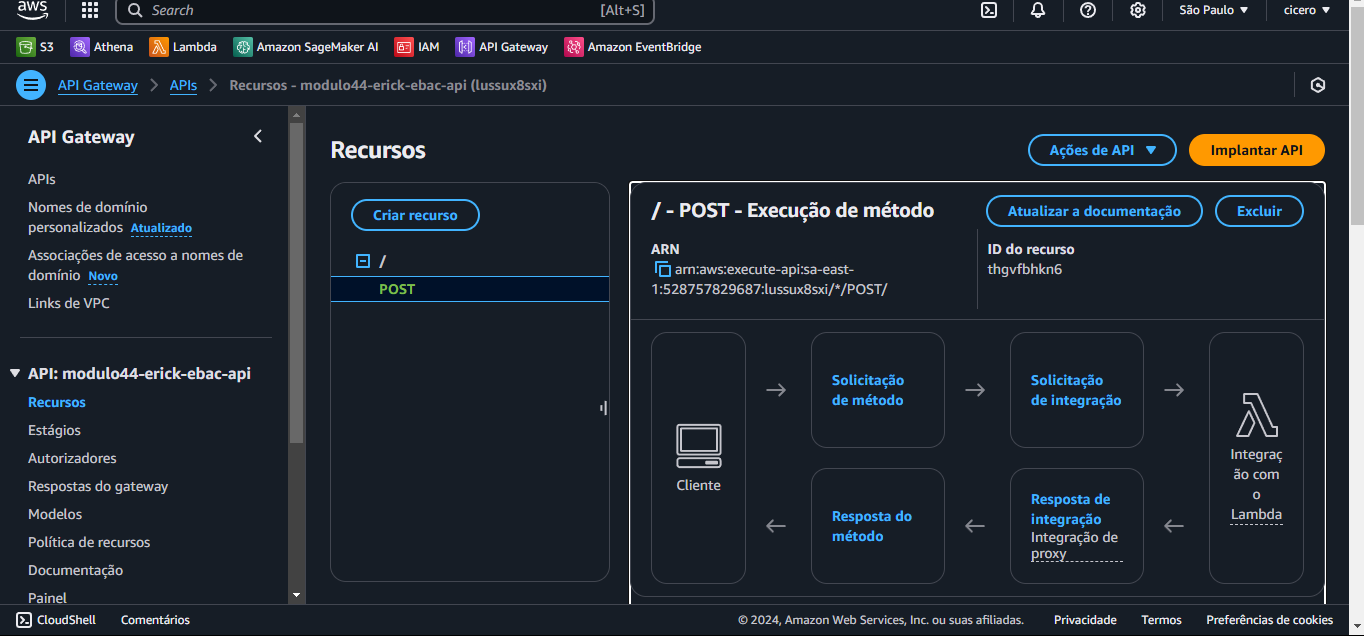

Podemos testar a integração com o  AWS Lambda através da ferramenta de testes do serviço. Por fim, vamos fazer a implantação da API e obter o seu endereço web.

• Selecione: Actions -> Deploy API;

• Selecione: New Stage para Deployment stage;

• Adicione dev como  Stage name.

Copie o a  url gerada na variável aws_api_gateway_url .

In [ ]:
aws_api_gateway_url=getpass()

··········


##1.4. **Telegram**

Vamos configurar o webhook para redirecionar as mensagens para a  url do  AWS API  Gateway.

• **setWebhook**

O método setWebhook configura o redirecionamento das mensagens captadas pelo bot para o endereço web do parametro  url.

Nota: os métodos getUpdates e setWebhook são mutuamente exclusivos, ou seja, enquanto o webhook estiver ativo, o método getUpdates não funcionará. Para desativar o webhook, basta utilizar o método deleteWebhook.

.Obs: essa mensagem não é a mesma lá de cima

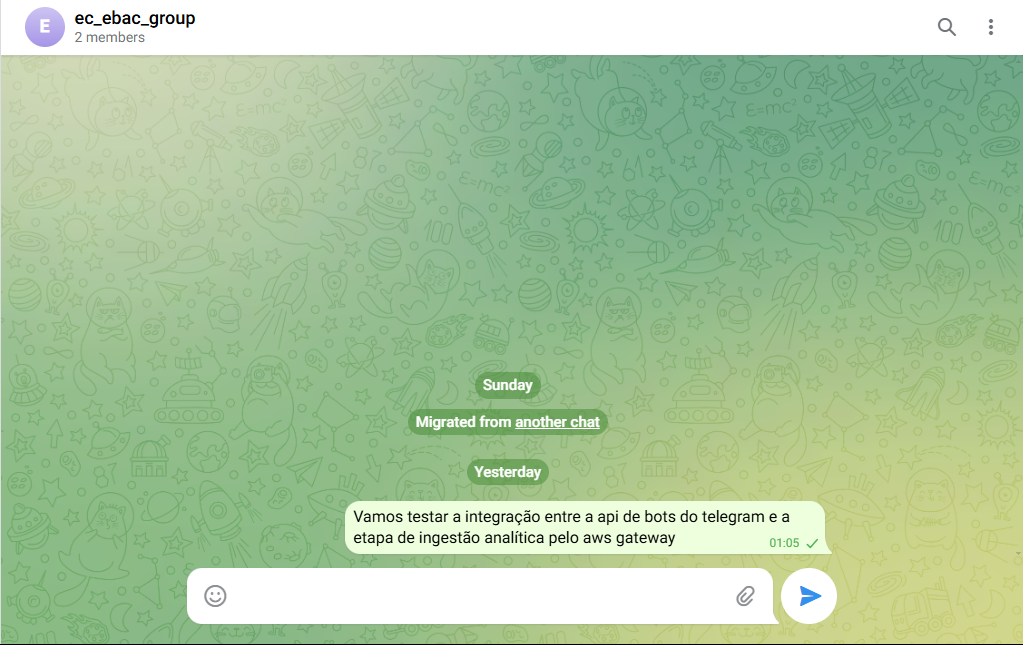

In [ ]:
response=requests.get(url=f'{base_url}/setWebhook?url={aws_api_gateway_url}')
print(json.dumps(json.loads(response.text), indent=2))

{
  "ok": true,
  "result": true,
  "description": "Webhook is already set"
}


• **getWebhookInfo**

O método getWebhookInfo retorna as informações sobre o webhook configurado.

In [ ]:
response=requests.get(url=f'{base_url}/getWebhookInfo')
print(json.dumps(json.loads(response.text), indent=2))

{
  "ok": true,
  "result": {
    "url": "https://lussux8sxi.execute-api.sa-east-1.amazonaws.com/dev",
    "has_custom_certificate": false,
    "pending_update_count": 0,
    "max_connections": 40,
    "ip_address": "54.207.190.241"
  }
}


#2.ETL

A etapa de **extração, transformação e carregamento** (do inglês extraction, transformation and load ou ETL) é uma etapa abrangente responsável pela manipulação dos dados ingeridos de sistemas transacionais, ou seja, já persistidos em camadas cruas ou raw de sistemas analíticos. Os processos conduzidos nesta etapa variam bastante de acordo com a área da empresa, do volume/variedade/velocidade do dado consumido, etc. Contudo, em geral, o dado cru ingerido passa por um processo recorrente de data wrangling onde o dado é limpo, deduplicado, etc. e persistido com técnicas de particionamento, orientação a coluna e compressão. Por fim, o dado processado está pronto para ser analisado por profissionais de dados.

No projeto, as mensagens de um único dia, persistidas na camada cru, serão compactadas em um único arquivo, orientado à coluna e comprimido, que será persistido em uma camada enriquecida. Além disso, durante este processo, o dado também passará por etapas de data wrangling.

Para isso, vamos utilizar uma função do  AWS Lambda como motor de processamento e um bucket do  AWS S3 como camada enriquecida para a persistência do dado processado. Para garantir a recorrência, vamos configurar uma regra do  AWS Event  Bridge como gatilho diário da função.

##2.1.1. AWS S3

Na etapa de ETL, o AWS S3 tem a função de passivamente armazenar as mensagens processadas de um dia em um único arquivo no formato Parquet. Para tanto, basta a criação de um bucket. Como padrão, vamos adicionar o sufixo –enriched ao seu nome (vamos seguir esse padrão para todos os serviços desta camada).

**Nota**: um  data lake é o nome dado a um repositório de um grande volume de dados. É organizado em zonas que armazenam replicadas dos dados em diferentes níveis de processamento. A nomenclatura das zonas varia, contudo, as mais comuns são: raw e enriched ou bronze, silver e gold.

##2.2. AWS Lambda

Na etapa de ETL, o  AWS Lambda tem a função de ativamente processar as mensagens captadas pelo bot do Telegram, persistidas na camada cru no bucket do  AWS S3, e persisti-las na camada enriquecida, também em um bucket do AWS S3.

Logo, vamos criar uma função que opera da seguinte forma:

• Lista todos os arquivos JSON de uma única participação da camada crua de um bucket do  AWS S3;

• Para cada arquivo listado:    
- Faz o download do arquivo e carrega o conteúdo da mensagem;     
- Executa uma função de data wrangling;     
- Cria uma tabela do PyArrow e a contatena com as demais

• Persiste a tabela no formato Parquet na camada enriquecida em um bucket do  AWS S3.

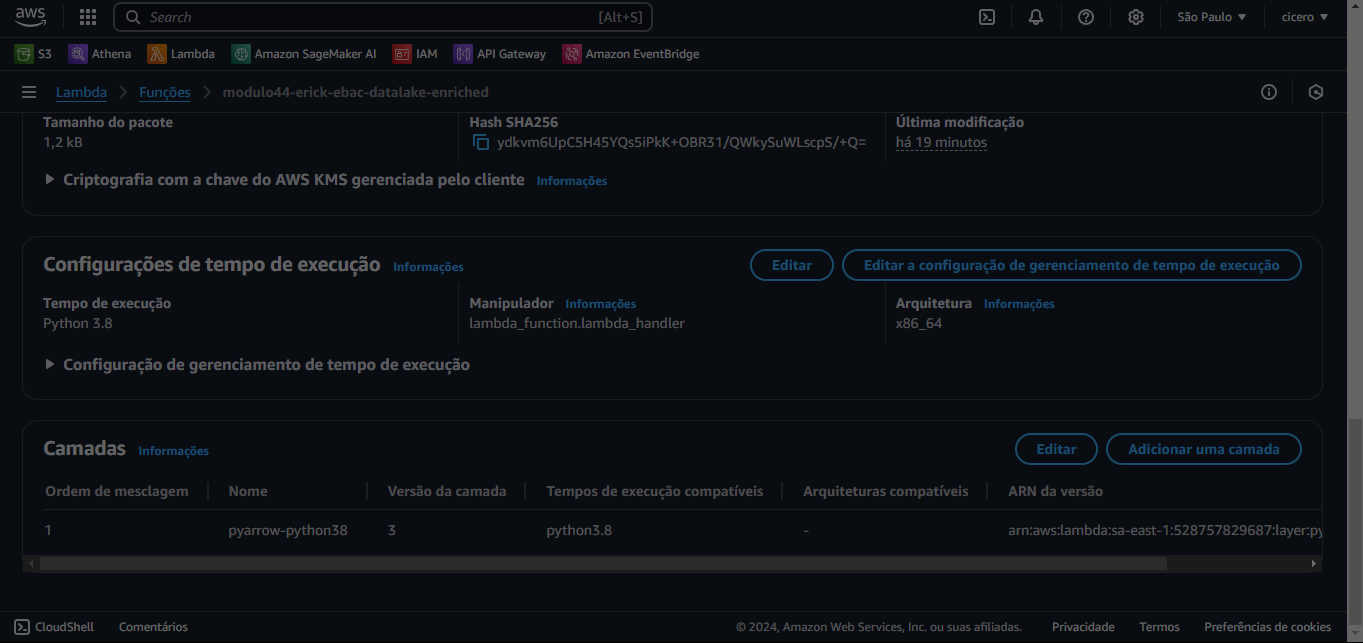

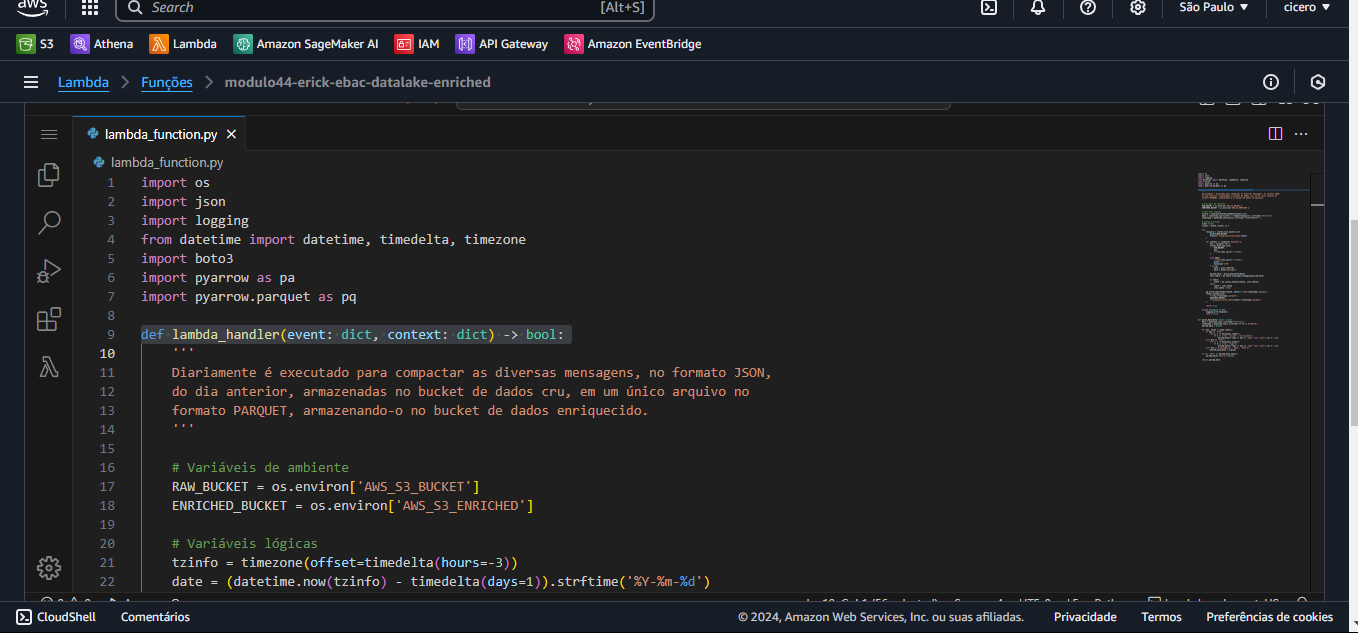

**Nota**: O fato de utilizarmos duas camadas de armazenamento e processamento, permite que possamos reprocessar os dados crus de diversas maneiras, quantas vezes forem preciso.

**Nota**: Atente-se ao fato de que a função processa as mensagens do dia anterior (D-1).

O código da função:

In [ ]:
!pip install boto3

In [ ]:
import os
import json
import logging
from datetime import datetime, timezone, timedelta
import boto3
import pyarrow as pa
import pyarrow.parquet as pq

def lambda_handler(event: dict, context: dict) -> bool:
    '''Diariamente é executado para compactar as diversas mensagens, no formato JSON, do dia anterior,
       armazenadas no bucket de dados cru, em um único arquivo no formato PARQUET, armazenando-o no bucket
       de dados enriquecido'''

    # Variáveis de ambiente
    RAW_BUCKET = os.environ['AWS_S3_BUCKET']
    ENRICHED_BUCKET = os.environ['AWS_S3_ENRICHED']

    # Variáveis lógicas
    tzinfo = timezone(offset=timedelta(hours=-3))
    date = (datetime.now(tzinfo) - timedelta(days=1)).strftime('%Y-%m-%d')
    timestamp = datetime.now(tzinfo).strftime('%Y%m%d%H%M%S%f')

    # Código principal
    table = None
    client = boto3.client('s3')

    try:
        response = client.list_objects_v2(
            Bucket=RAW_BUCKET,
            Prefix=f'telegram/context_date={date}'
        )

        for content in response['Contents']:
            key = content['Key']
            client.download_file(RAW_BUCKET, key, f"/tmp/{key.split('/')[-1]}")

            with open(f"/tmp/{key.split('/')[-1]}", mode='r', encoding='utf8') as fp:
                data = json.load(fp)
                data = data["message"]

            parsed_data = parse_data(data=data)
            iter_table = pa.Table.from_pydict(mapping=parsed_data)

            if table:
                table = pa.concat_tables([table, iter_table])
            else:
                table = iter_table
                iter_table = None

        pq.write_table(table=table, where=f'/tmp/{timestamp}.parquet')
        client.upload_file(f"/tmp/{timestamp}.parquet", ENRICHED_BUCKET, f"telegram/context_date={date}/{timestamp}.parquet")

        return True

    except Exception as exc:
        logging.error(msg=exc)
        return False


O código da função data wrangling:

In [ ]:
def parse_data(data: dict) -> dict:
    date = datetime.now().strftime('%Y-%m-%d')
    timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    parsed_data = dict()

    for key, value in data.items():
        if key == 'from':
            for k, v in data[key].items():
                if k in ['id', 'is_bot', 'first_name']:
                    parsed_data[f"{key if key == 'chat' else 'user'}_{k}"] = [v]
        elif key == 'chat':
            for k, v in data[key].items():
                if k in ['id', 'type']:
                    parsed_data[f"{key if key == 'chat' else 'user'}_{k}"] = [v]
        elif key in ['message_id', 'date', 'text']:
            parsed_data[key] = [value]

    if not 'text' in parsed_data.keys():
        parsed_data['text'] = [None]
    return parsed_data

Para que a função funcione corretamente, algumas configurações precisam ser realizadas.

**• Variáveis do ambiente**

Note que o código exige a configuração de duas variáveis de ambiente: AWS_S3_BUCKET e  AWS_S3_ENRICHED com os nomes dos bucket do  AWS S3 da camada cru e enriquecida, respectivamente. Para adicionar variáveis de ambiente em uma função do AWS Lambda, basta acessar configurações -> variáveis de ambiente no console da função.

**• Permissão**

Precisamos adicionar a permissão de escrita nos buckets do  AWS S3 para a função do AWS Lambda no  AWS IAM.

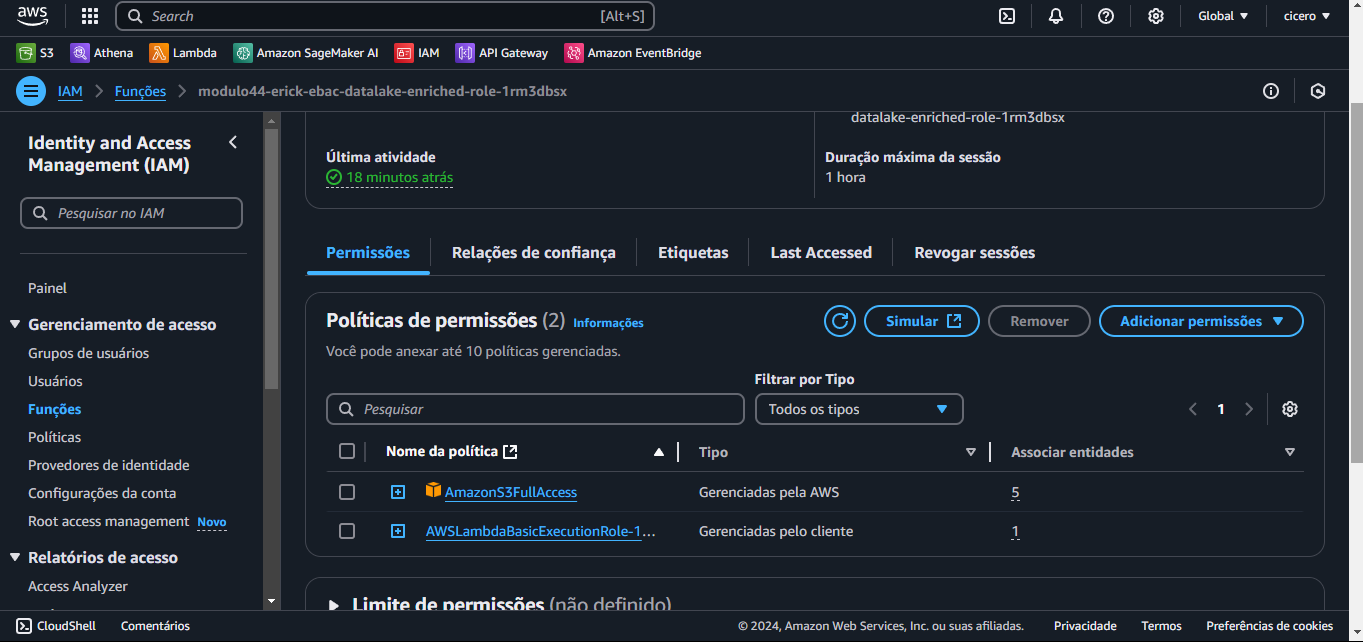

**• Recursos**

O timeout padrão de funções do  AWS Lambda é de 3 segundos. Para a função, vamos aumentar o tempo para 5 minutos, principalmente para lidar com o IO (input/output) de arquivos do  AWS S3.

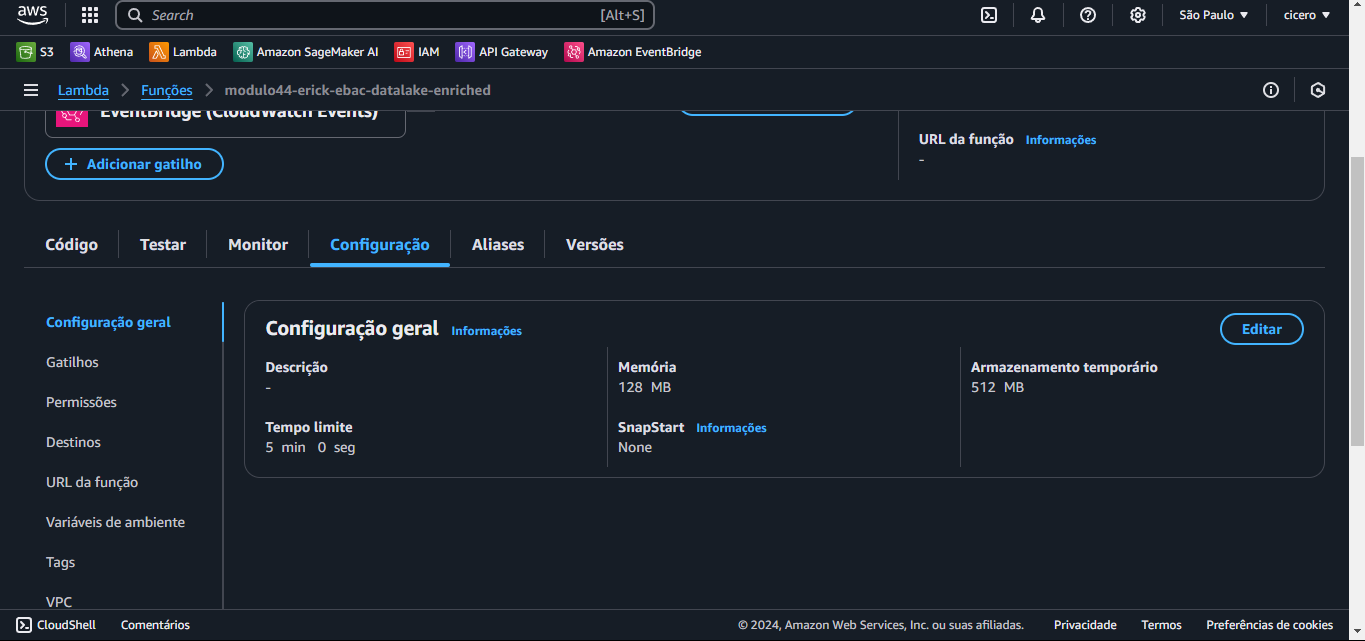

**• Camadas**

Por fim, note que o código da função utiliza o pacote Python PyArrow. Contudo, o ambiente padrão do  AWS Lambda possui poucos pacotes externos instalados, como o pacote Python boto3, logo o PyArrow não será encontrado e a execução da função falhará. Existem algumas formas de adicionar pacotes externos no ambiente de execução do AWS Lambda, um deles é a criação de camadas ou layers, onde podemos fazer o upload dos pacotes Python direto na plataforma ou através de um bucket do  AWS S3.Vamos então seguir com a última opção, onde teremos que:

• Criar um bucket no  AWS S3; • Fazer o upload do código do pacote Python do PyArrow (download no link https://github.com/aws/aws-sdk-pandas/releases); • Criar layer e conectar na função.

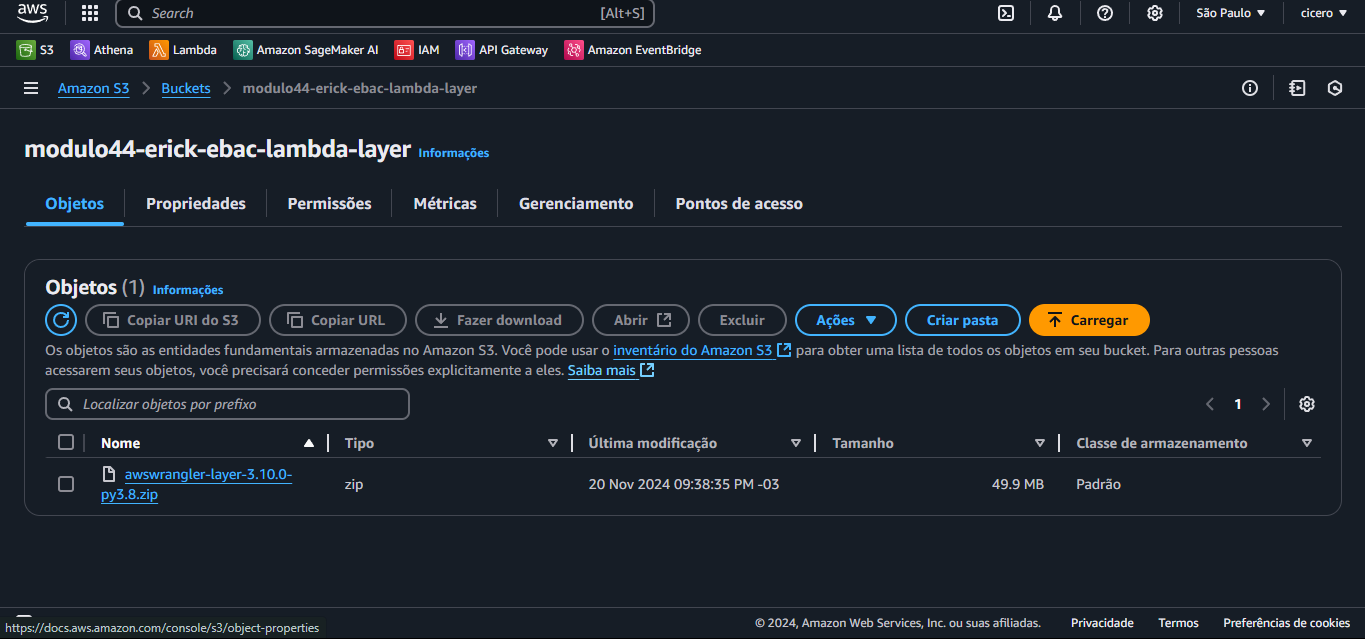

##**2.3. AWS Event Bridge**

Na etapa de **ETL**, o AWS Event Bridge tem a função de ativar diariamente a função de ETL do AWS Lambda, funcionando assim como um scheduler.

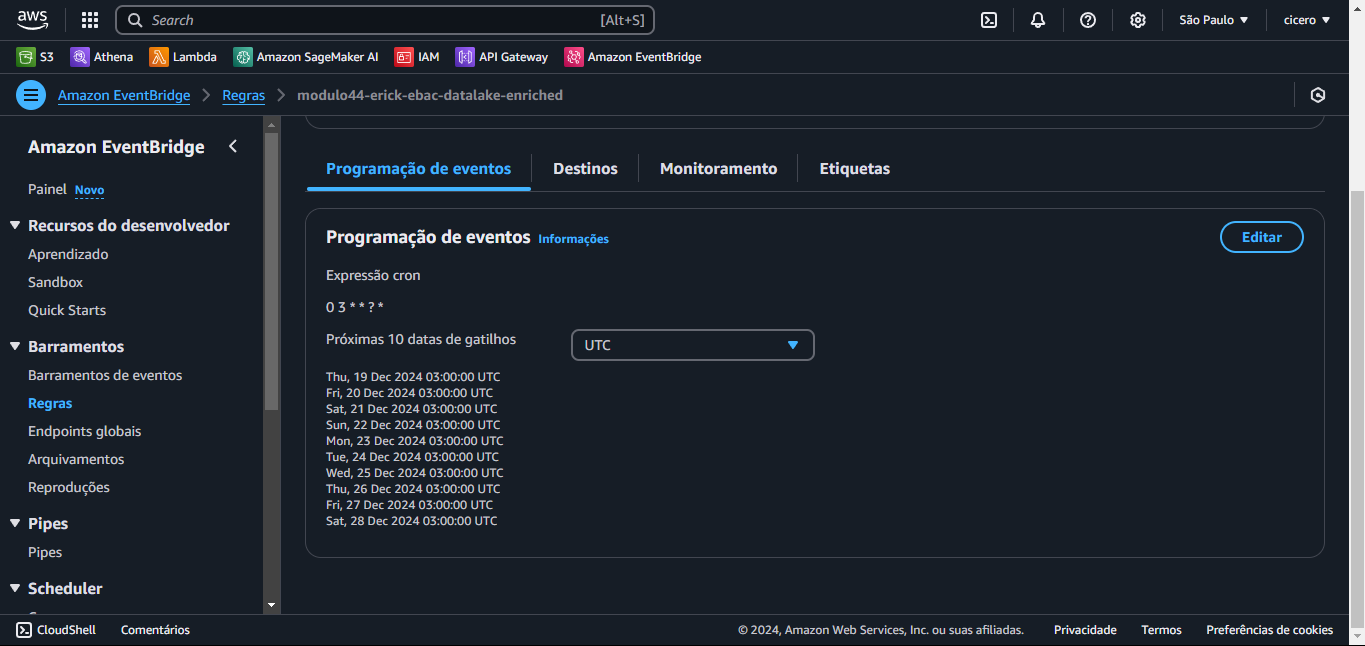

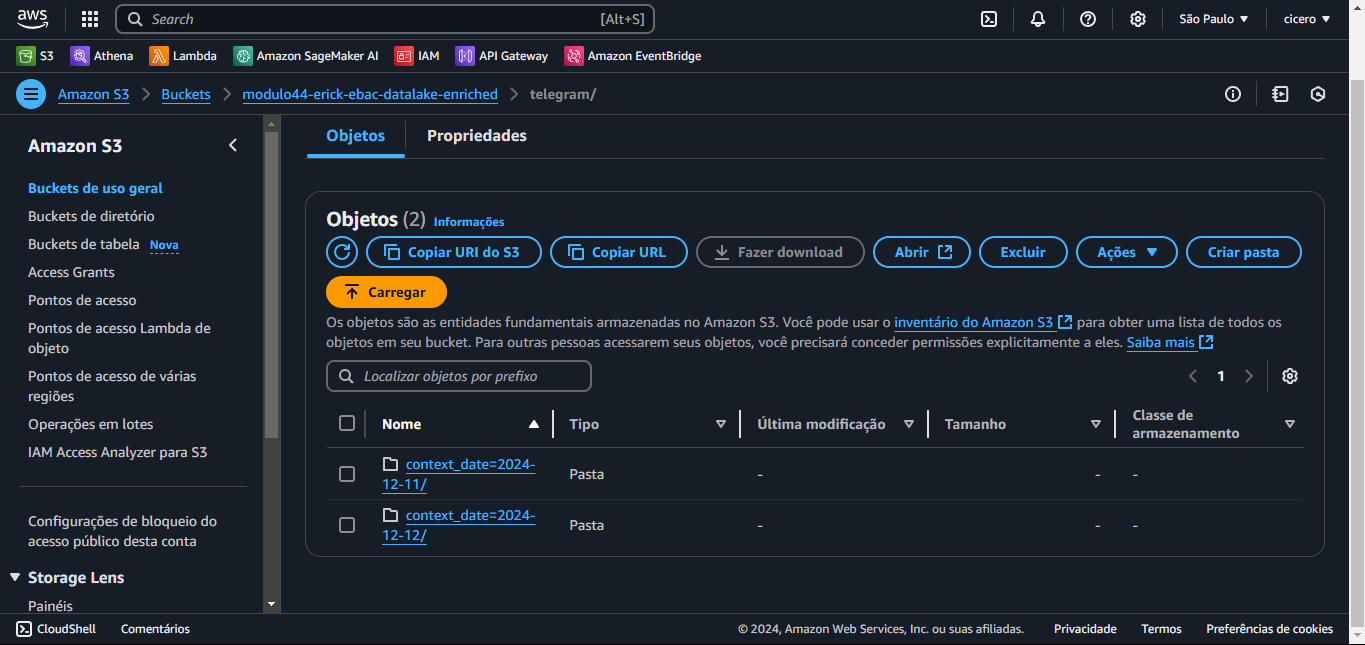

**Nota**: Atente-se ao fato de que a função processa as mensagens do dia anterior (D-1).

#**3.Apresentação**

A etapa de **apresentação** é responsável por entregar o dado para os usuários (analistas, cientistas, etc.) e sistemas (dashboards, motores de consultas, etc.), idealmente através de uma interface de fácil uso, como o SQL, logo, essa é a única etapa que a maioria dos usuários terá acesso. Além disso, é importante que as ferramentas da etapa entreguem dados armazenados em camadas refinadas, pois assim as consultas são mais baratas e os dados mais consistentes.

##**3.1.AWS Athena**

Na etapa de **apresentação**, o  AWS Athena tem função de entregar o dados através de uma interface SQL para os usuários do sistema analítico. Para criar a interface, basta criar uma tabela externa sobre o dado armazenado na camada mais refinada da arquitetura, a camada enriquecida.

CREATE EXTERNAL TABLE telegram(

  message_id BIGINT,
  
  user_id BIGINT,
  
  user_is_bot BOOLEAN,
  
  user_first_name STRING,
  
  chat_id BIGINT,
  
  chat_type STRING,
  
  text STRING,
  
  date BIGINT

)
PARTITIONED BY (

  context_date DATE

)
ROW FORMAT SERDE

  'org.apache.hadoop.hive.ql.io.parquet.serde.
  
  ParquetHiveSerDe'

STORED AS INPUTFORMAT

  'org.apache.hadoop.hive.ql.io.parquet.
  
  MapredParquetInputFormat'

OUTPUTFORMAT
  
  'org.apache.hadoop.hive.ql.io.parquet.
  
  MapredParquetOutputFormat'

LOCATION
  's3://< bucket-enriquecido>/'


Por fim, adicione as partições disponíveis.

Importante: Toda vez que uma nova partição é adicionada ao repositório de dados, é necessário informar o AWS Athena para que a ela esteja disponível via SQL. Para isso, use o comando SQL  MSCK REPAIR TABLE < nome-tabela> para todas as partições (mais caro) ou  ALTER TABLE < nome-tabela> ADD PARTITION < coluna-partição> = < valor- partição> para uma única partição (mais barato), documentação no link https://docs.aws.amazon.com/athena/latest/ug/alter-table-add-partition.html.

##3.2.Analytics

Com o dado disponível, usuários podem executar as mais variadas consultas analíticas. Seguem alguns exemplos:

• Quantidade de mensagens por dia.


SELECT context_date, count(1) AS
"message_amount" FROM "telegram"

GROUP BY context_date

ORDER BY context_date DESC

• Quantidade de mensagens por usuário por dia.

SSELECT user_id, user_first_name, context_date, count(1) AS "message_amount"




FROM "telegram"

GROUP BY user_id, user_first_name, context_date

ORDER BY context_date DESC

• Média do tamanho das mensagens por usuário por dia.

WITH
    parsed_date_cte AS (
        SELECT
            *,
            CAST(date_format(from_unixtime("date"),'%Y-%m-%d %H:%i:%s') AS timestamp) AS parsed_date
        FROM "telegram"
    ),

    hour_week_cte AS (
        SELECT
            *,
            EXTRACT(hour FROM parsed_date) AS parsed_date_hour,
            EXTRACT(dow FROM parsed_date) AS parsed_date_weekday,
            EXTRACT(week FROM parsed_date) AS parsed_date_weeknum
        FROM parsed_date_cte
    )

SELECT
    parsed_date_hour,
    parsed_date_weekday,
    parsed_date_weeknum,
    COUNT(1) AS "message_amount"
FROM hour_week_cte
GROUP BY
    parsed_date_hour,
    parsed_date_weekday,
    parsed_date_weeknum
ORDER BY
    parsed_date_weeknum,
    parsed_date_weekday;
